In [1]:
import os
import symbolica
symbolica.set_license_key(os.environ["SYMBOLICA_KEY_UNI"])
from symbolica import S, E, N
from IPython.display import display_latex, Latex
import matplotlib.pyplot as plt
import numpy as np

┌────────────────────────────────────────────────────────┐
│ You are running a restricted Symbolica instance.       │
│                                                        │
│ This mode is only permitted for non-commercial use and │
│ is limited to one instance and core per machine.       │
│                                                        │
│ Hobbyists can easily acquire a free license key        │
│ that unlocks all cores and removes this banner:        │
│                                                        │
│   from symbolica import *                              │
│   request_hobbyist_license('YOUR_NAME', 'YOUR_EMAIL')  │
│                                                        │
│ All other users can obtain a free 30-day trial key:    │
│                                                        │
│   from symbolica import *                              │
│   request_trial_license('NAME', 'EMAIL', 'EMPLOYER')   │
│                                                       

In [2]:
i = symbolica.Expression.I
q1, q2, p11, p12, p21, p22, m = S('q1','q2', 'p11', 'p12','p21','p22', 'm')
eps = S('e') #greek letters dont work as expected, therefore use e

def pcr(E, p):
    return 1/(E**2-p**2 - m**2 + i*eps)

integrand = -i * pcr(q1, q2)*pcr(q1+p11, q2+p12)*pcr(q1-p21, q2-p22)

display_latex(Latex(integrand.to_latex()))

In [3]:
integrand_eval = integrand.evaluator({
    m:      symbolica.Expression.num(0),
    eps:    symbolica.Expression.num(1)/1000,
    p11:    symbolica.Expression.num(1),
    p12:    symbolica.Expression.num(0),
    p21:    symbolica.Expression.num(1),
    p22:    symbolica.Expression.num(0),
},{},
    [q1, q2])

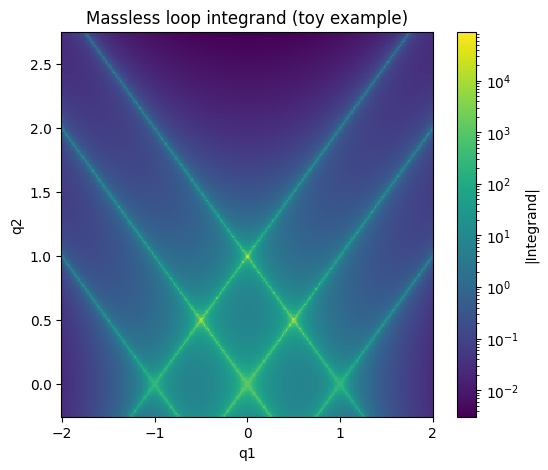

In [4]:
# Create a NumPy meshgrid for q1, q2
from matplotlib.colors import LogNorm


q1_vals = np.linspace(-2, 2, 300)
q2_vals = np.linspace(-0.25, 2.75, 300)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Evaluate the integrand on the grid
Z = np.zeros_like(Q1, dtype=np.complex128)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        Z[i,j] = integrand_eval.evaluate_complex([[Q1[i,j], Q2[i,j]]])[0][0]

# Plot the absolute value of the integrand
plt.figure(figsize=(6,5))
plt.pcolormesh(Q1, Q2, np.abs(Z), shading='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='|Integrand|')
plt.xlabel('q1')
plt.ylabel('q2')
plt.title('Massless loop integrand (toy example)')
plt.show()

In [5]:
class SymbolicaLorenzVec:
    def __init__(self, symbols : list):
        self.symbols = symbols
    @staticmethod
    def from_name(name):
        symbols = [symbolica.S(f'{name}_{i}')for i in range(4)]
        return SymbolicaLorenzVec(symbols)
    
    def t(self):
        return self.symbols[0]

    def spacial(self):
        return SymbolicaVec(self.symbols[1:])
    
    def get_subs_dict(self, values):
        return {sym : N(num) for sym, num in zip(self.symbols, values)}
    
    def __add__(self, other):
        if isinstance(other, SymbolicaLorenzVec):
            return SymbolicaLorenzVec([a+b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __sub__(self, other):
        if isinstance(other, SymbolicaVec):
            return SymbolicaVec([a-b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __mul__(self, other):
        if isinstance(other, SymbolicaLorenzVec):
            return self.symbols[0]*other.symbols[0]-self.spacial()*other.spacial()
        return [a*other for a in self.symbols]
    def __str__(self):
        return str(self.symbols)

class SymbolicaVec:
    def __init__(self, symbols : list):
        self.symbols = symbols
    @staticmethod
    def from_name(name):
        values = [symbolica.E(f'{name}_{i}')for i in range(1,4)]
        return SymbolicaVec(values)
    
    def __add__(self, other):
        if isinstance(other, SymbolicaVec):
            return SymbolicaVec([a+b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __sub__(self, other):
        if isinstance(other, SymbolicaVec):
            return SymbolicaVec([a-b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __mul__(self, other):
        if isinstance(other, SymbolicaVec):
            return sum(a*b for a, b in zip(self.symbols, other.symbols))
        return [a*other for a in self.symbols]
    def __str__(self):
        return str(self.symbols)
    
k = SymbolicaLorenzVec.from_name('k')
print(k * k)

k_0^2-(k_1^2+k_2^2+k_3^2)


In [6]:
from typing import Literal, Protocol
from numpy.typing import NDArray

class WrappedEvaluator(Protocol):
    def __call__(self, mass: complex, loop_momenta: list[NDArray], k: NDArray) -> complex:
        pass

class IntegrandBuilder:
    loop_momenta : list[SymbolicaLorenzVec]
    mass : complex
    integrand : SymbolicaVec
    def __init__(self): 
        self.loop_momenta = list(map(SymbolicaLorenzVec.from_name, ['q0', 'q1', 'q2']))
        self.mass = S('m')
        self.integrand = SymbolicaVec.from_name('k')
    
    def ose(self, i: int):
        temp = self.integrand - self.loop_momenta[i].spacial()
        return (temp*temp + self.mass * self.mass)**(N(1)/2)
    
    def eta(self, i: int, j: int):
        return self.ose(i) + self.ose(j) + self.loop_momenta[i].t() - self.loop_momenta[j].t()
    
    def improved_ltd_prefactor(self):
        return (4*symbolica.Expression.PI)**N(-3)/(self.ose(0)*self.ose(1)*self.ose(2))

    def improved_ltd_part(self, i, j, k, l):
        return 1/(self.eta(i,j)*self.eta(k, l))
    
    def improved_ltd_expression(self) -> symbolica.Expression:
        return self.improved_ltd_prefactor()*(
            self.improved_ltd_part(0,1,0,2)+
            self.improved_ltd_part(1,0,2,0)+
            self.improved_ltd_part(1,0,1,2)+
            self.improved_ltd_part(0,1,2,1)+
            self.improved_ltd_part(2,0,2,1)+
            self.improved_ltd_part(0,2,1,2)
            )
    
    def evaluator_args(self):
        return [symbolica.Expression.PI, self.mass] + [sym for m in self.loop_momenta for sym in m.symbols] + self.integrand.symbols


    def get_evaluator(self, e: symbolica.Expression) -> symbolica.Evaluator:
        return e.evaluator({},{}, self.evaluator_args())
    
    def get_wrapped_evaluator(self, e: symbolica.Expression) -> WrappedEvaluator:
        evaluator = self.get_evaluator(e)
        def wrapped(mass: complex, loop_momenta: list[NDArray], k: NDArray):
            return evaluator.evaluate_complex([[np.pi, mass] + [q for qs in loop_momenta for q in qs] + list(k)])
        return wrapped
    
    def loop_momenta_from_external(self, p1: NDArray, p2: NDArray, q_0: NDArray | None = None):
        if q_0 is None:
            q_0 = np.array([0,0,0,0])
        return [q_0, q_0-p1, q_0+p2]


from integrand_builder import IntegrandBuilder

b = IntegrandBuilder()
wrapped_evaluator = b.get_wrapped_evaluator(b.improved_ltd_expression())

In [8]:
p1 = np.array([4,1,0,-1])
p2 = np.array([4,0,1,-1])
mass = 1-0.1j

def slice_sampler(k1, k2, x, y):
    k = np.zeros(3)
    k[x] = k1
    k[y] = k2
    return wrapped_evaluator(mass, p1, p2, k)

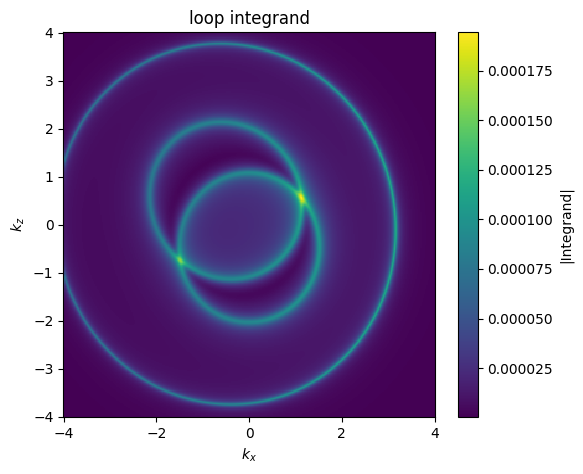

In [9]:
from matplotlib.colors import LogNorm




k1 = np.linspace(-4, 4, 300)
k2 = np.linspace(-4, 4, 300)
K1, K2 = np.meshgrid(k1, k2)

ax1 = 0
ax2 = 2

# Evaluate the integrand on the grid
Z = np.zeros_like(K1, dtype=np.complex128)
for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        Z[i,j] = slice_sampler(K1[i,j], K2[i,j], ax1, ax2)[0][0]


axes = ['x', 'y', 'z']

plt.figure(figsize=(6,5))
plt.pcolormesh(K1, K2, np.abs(Z), shading='auto', cmap='viridis')
plt.colorbar(label='|Integrand|')
plt.xlabel(f'$k_{axes[ax1]}$')
plt.ylabel(f'$k_{axes[ax2]}$')
plt.title('loop integrand')
plt.show()

In [ ]:
def theta(*args):
    return 1 if args[0][0] > 0 else 0
expr = E('theta(x)')
print(expr)
evaluator = expr.evaluator({},{}, [S('x')], external_functions={(S('theta'), 'Theta') : theta})

print(evaluator.evaluate([[1],[0]]))